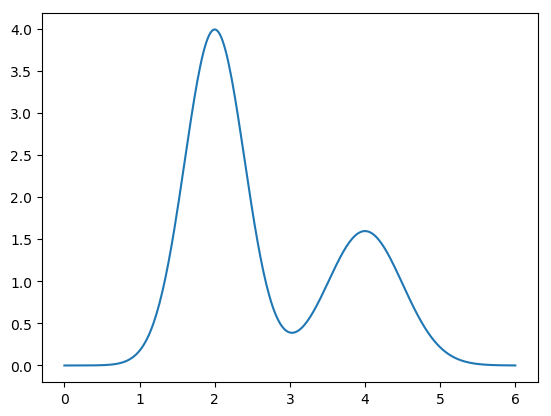

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1366143c8>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("triangular")(x, y)
end

kernel (generic function with 1 method)

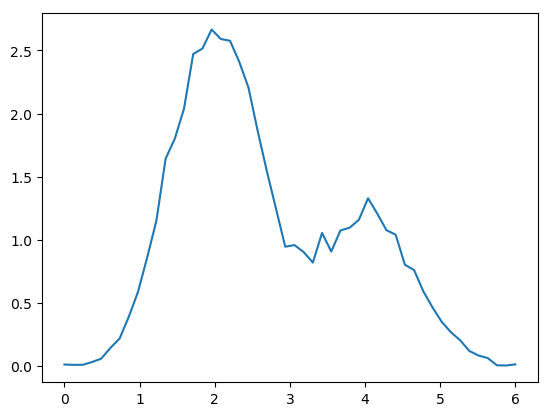

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1367a67b8>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [4]:
basis = FourierBasis(a, b, 25)

FourierBasis(0.0, 6.0, 25, BaseFunction[BaseFunction(##19#23(), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0))  …  BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 21), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 21), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 22), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 22), (0.0, 

In [5]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

50×51 Array{Float64,2}:
 0.250001  -0.455947   -0.16521    0.341958   …  -0.000729514  -0.0369338  
 0.307476  -0.545703   -0.229673   0.373398       0.0037239    -0.0346407  
 0.357456  -0.611526   -0.304106   0.365501      -0.000873095  -0.0278694  
 0.399935  -0.652334   -0.385436   0.318785       0.00384864   -0.0249873  
 0.434922  -0.667458   -0.470331   0.236305      -0.000978522  -0.0188212  
 0.462411  -0.656641   -0.555503   0.123459   …   0.00393409   -0.0153206  
 0.482401  -0.620082   -0.63763   -0.0123768     -0.00104332   -0.00978408 
 0.494901  -0.558367   -0.713458  -0.162314       0.00397899   -0.00564557 
 0.499892  -0.472505   -0.779792  -0.316543      -0.00106802   -0.000752764
 0.499998  -0.369117   -0.833841  -0.459794       0.00122387    0.000795912
 0.5       -0.259458   -0.874202  -0.573184   …  -0.00116868   -0.000873727
 0.499999  -0.145537   -0.900201  -0.648248       0.00110874    0.000946394
 0.499993  -0.0292275  -0.911425  -0.682509      -0.0010468    -

In [6]:
model = model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[0.0 0.0 … 0.0 0.0; 0.0 1.80387 … 0.0 0.0; … ; 0.0 0.0 … 7.04638e5 0.0; 0.0 0.0 … 0.0 7.04638e5]], 51, "EmpiricalBayes", nothing)

In [7]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -3.801505e+02     8.368429e+00
     1    -3.855521e+02     3.698345e+00
     2    -3.907085e+02     8.130976e-01
     3    -3.908404e+02     5.125018e-02
     4    -3.908408e+02     1.693342e-05
     5    -3.908408e+02     1.844805e-09
Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0]
 * Minimizer: [-2.5442104261340686]
 * Minimum: -3.908408e+02
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 1.0e-08: false 
     |x - x'| = 6.13e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = -1.33e-13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.84e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 12
 * Gradient Calls: 12
ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.078535]
  "coeff"  => [1.96041, 0.871248, -0.538845, -0.634633, -0.453598, -0.654412, -…
  "sig"    => [0.00514212 0.00155156 … -2.02276e-8 -4.7128e-9; 0.00155156 0.002…

In [8]:
phivec = PhiVec(result["coeff"], basis, result["sig"])

PhiVec([1.96041, 0.871248, -0.538845, -0.634633, -0.453598, -0.654412, -0.0247777, -0.0406169, 0.0534369, 0.00134182  …  -1.62937e-6, -7.47589e-6, -2.51063e-7, 6.83154e-6, 1.28233e-7, -5.12858e-6, -1.334e-7, 4.00345e-6, 2.35374e-7, -3.36488e-6], FourierBasis(0.0, 6.0, 25, BaseFunction[BaseFunction(##19#23(), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0))  …  BaseFunction(##20#24{Float64,Float6

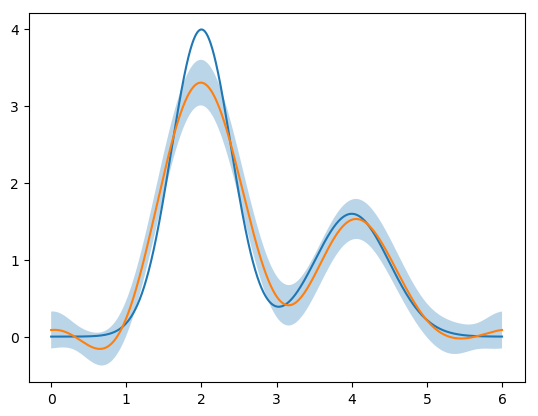

In [9]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3);